In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# Load keras
import keras
from keras.layers import Input, LSTM, Dense, Flatten, MaxPooling2D, Dropout, Activation, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator

c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import os, fnmatch
from skimage import io, transform
import numpy as np
from tqdm import tqdm
import pandas as pd
import shutil

In [35]:
vgg16 = keras.applications.vgg16.VGG16(include_top=False, #weights=None,
                                       weights='imagenet',
                                       input_tensor=None, input_shape=(224,224,3))
vgg16_full = keras.applications.vgg16.VGG16(include_top=True, #weights=None, 
                                            weights='imagenet',
                                            input_tensor=None, input_shape=(224,224,3))

In [36]:
fc1_layer = vgg16_full.get_layer("fc1")
fc1_layer
fc2_layer = vgg16_full.get_layer("fc2")
fc2_layer


In [8]:
labels_csv = pd.read_csv("labels.csv")

In [9]:
breeds = pd.Series(labels_csv['breed'])
filenames = pd.Series(labels_csv['id'])

In [10]:
unique_breeds = np.unique(breeds)
labels = []
for breed in breeds:
    i = np.where(unique_breeds == breed)[0][0]
    labels.append(i)

n_breeds = np.max(labels) + 1
labels = np.eye(n_breeds)[labels]

In [11]:
filenames_train = []
filenames_validate = []

# move to validate folder
for i in tqdm(range(len(filenames))):
    label = unique_breeds[np.where(labels[i]==1.)][0]
    filename = '{}.jpg'.format(filenames[i])

    if i < 8000:
        new_dir = './sorted/train/{}/'.format(label)
        filenames_train.append(new_dir + filename)
    else:
        new_dir = './sorted/validate/{}/'.format(label)
        filenames_validate.append(new_dir + filename)
        
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
    
    #shutil.move("train/{}.jpg".format(filenames[i]), new_dir + filename)

100%|█████████████████████████████████████████████████████████████████████████| 10222/10222 [00:00<00:00, 14311.11it/s]


In [12]:
indices_train = np.argsort(filenames_train)
indices_val = np.argsort(filenames_validate)

sorted_filenames_train = np.array(filenames_train)[indices_train]
sorted_filenames_validate = np.array(filenames_validate)[indices_val]
sorted_labels_train = np.array(labels)[0:8000][indices_train]
sorted_labels_validate = np.array(labels)[8000:][indices_val]

In [13]:
print(sorted_filenames_train.shape)
print(sorted_labels_train.shape)

print(sorted_filenames_validate.shape)
print(sorted_labels_validate.shape)

(8000,)
(8000, 120)
(2222,)
(2222, 120)


In [14]:
print(unique_breeds[np.where(sorted_labels_train[50] == 1.)])
# should be equal to:
print(sorted_filenames_train[50])

['affenpinscher']
./sorted/train/affenpinscher/a2702282275212144b1683a434651d7f.jpg


In [15]:
def preprocess(img):
    input_img = preprocess_input(np.expand_dims(img, axis=0))
    return input_img[0]

train_datagen = ImageDataGenerator(preprocessing_function=preprocess)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess)

In [16]:
# subset of data
batch_size = 64

train_gen = train_datagen.flow_from_directory("sorted/train", 
                                              batch_size=batch_size, 
                                              target_size=(224, 224), 
                                              shuffle=False)

val_gen = val_datagen.flow_from_directory("sorted/validate", 
                                          batch_size=batch_size, 
                                          target_size=(224, 224), 
                                          shuffle=False)

Found 8000 images belonging to 120 classes.
Found 2222 images belonging to 120 classes.


In [17]:
x_train = vgg16.predict_generator(train_gen, steps=8000 // batch_size, verbose=2)

In [18]:
x_val = vgg16.predict_generator(val_gen, steps=2222 // batch_size, verbose=2)

In [19]:
y_train = sorted_labels_train[0:len(x_train)]
y_val = sorted_labels_validate[0:len(x_val)]

In [37]:
inputs = Input(shape=(7,7,512))

# turn off training vgg16
for layer in vgg16.layers:
    layer.trainable = False

fc1_layer.trainable = False

# x = vgg16(inputs)
x = Flatten()(inputs)
x = fc1_layer(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
x = Dense(120, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
batch_normalization_9 (Batch (None, 4096)              16384     
_________________________________________________________________
dropout_9 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               2097664   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
__________

In [38]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])

In [54]:
history = model.fit(x_train, y_train, batch_size=1024, epochs=15, verbose=1, 
                    validation_data=(x_val, y_val))

# We should probably use early stopping here

c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 8000 samples, validate on 2176 samples
Epoch 1/15
8000/8000 [==============================] - ETA: 1s - loss: 0.9487 - acc: 0.712 - ETA: 1s - loss: 0.9482 - acc: 0.712 - ETA: 0s - loss: 0.9665 - acc: 0.711 - ETA: 0s - loss: 0.9709 - acc: 0.706 - ETA: 0s - loss: 0.9798 - acc: 0.704 - ETA: 0s - loss: 0.9641 - acc: 0.708 - ETA: 0s - loss: 0.9647 - acc: 0.706 - 2s 232us/step - loss: 0.9690 - acc: 0.7045 - val_loss: 0.8400 - val_acc: 0.7468
Epoch 2/15
8000/8000 [==============================] - ETA: 1s - loss: 0.9376 - acc: 0.710 - ETA: 1s - loss: 0.9493 - acc: 0.712 - ETA: 0s - loss: 0.9526 - acc: 0.713 - ETA: 0s - loss: 0.9565 - acc: 0.710 - ETA: 0s - loss: 0.9543 - acc: 0.711 - ETA: 0s - loss: 0.9572 - acc: 0.708 - ETA: 0s - loss: 0.9546 - acc: 0.708 - 2s 226us/step - loss: 0.9488 - acc: 0.7076 - val_loss: 0.8396 - val_acc: 0.7468
Epoch 3/15
8000/8000 [==============================] - ETA: 1s - loss: 0.9990 - acc: 0.707 - ETA: 1s - loss: 0.9783 - acc: 0.699 - ETA: 0s - loss: 

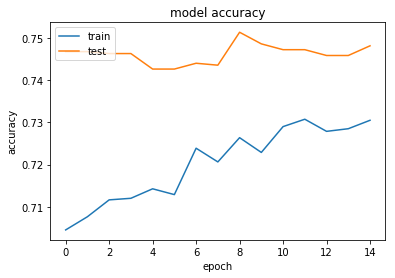

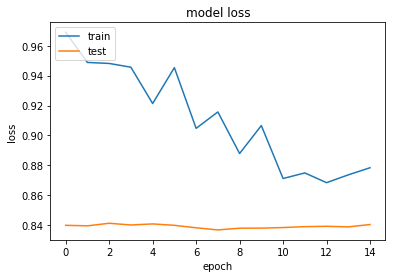

In [55]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [53]:
model.layers[2].trainable=True

In [62]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join('', train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img


INPUT_SIZE = 224
from os.path import join
from keras.preprocessing import image
sample_submission = pd.read_csv(join('', 'sample_submission.csv'))
for i, img_id in tqdm(enumerate(sample_submission['id'])):
    img = read_img(img_id, 'test', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    y = model.predict(vgg16.predict(x))
    sample_submission.iloc[i,1:121] = np.asarray(y[0,0:120])

10357it [12:47, 13.50it/s]


In [63]:
sample_submission.to_csv('submission5.csv',index=False)